# Importing

## Importing modules

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import time
import random
import math
from multiprocessing import Process, Queue

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.models import load_model
from keras.optimizers import SGD, adam, adagrad, rmsprop

## Importing own code

In [131]:
from generateSpace import *
from plotLattice import *
from getTriangleLengths import *
from potentialEnergyPerTrio import *
from potentialEnergy import *
from potentialEnergyPerParticle import *
from numberOfCalculations import *
from makeRandomDatabase import *
from prepareDatabaseForMachineLearning import*

## Writing own code

### Analysis code

In [132]:
def plotHistory(fitDetails):
    """
    hjhgj
    """
    history = {'loss': fitDetails.history['loss'], 'val_loss': fitDetails.history['val_loss']}
    
    maximumValue = max(max(history['loss']), max(history['val_loss']))
    minimumValue = min(min(history['loss']), min(history['val_loss'])) / 10#math.pow(math.floor(math.log(min(min(history['loss']), min(history['val_loss'])), 10)) - 1, 10)
    numberOfEpochs = len(history['loss'])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
    ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
    ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
    ax1.legend()
    ax1.set_xlim(1, numberOfEpochs)
    ax1.set_ylim(0, maximumValue)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss (training and validation) vs the number of epochs.')
    
    ax2.plot(history['loss'], history['val_loss'])
    ax2.set_xlim(0, maximumValue)
    ax2.set_ylim(0, maximumValue)
    ax2.set_xlabel('Training loss')
    ax2.set_ylabel('Validation loss')
    ax2.set_title('Validation loss vs training loss.')
    
    ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
    ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
    ax3.legend()
    ax3.set_xlim(1, numberOfEpochs)
    ax3.set_yscale('log')
    ax3.set_ylim(minimumValue, maximumValue)
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Loss')
    ax3.set_title('Loss (training and validation) vs the number of epochs (logarithmic)')
    
    ax4.plot(history['loss'], history['val_loss'])
    ax4.set_xscale('log')
    ax4.set_xlim(minimumValue, maximumValue)
    ax4.set_yscale('log')
    ax4.set_ylim(minimumValue, maximumValue)
    ax4.set_xlabel('Training loss')
    ax4.set_ylabel('Validation loss')
    ax4.set_title('Validation loss vs training loss (logarithmic).')
    
    plt.show()
    history['figure'] = [fig, ax1, ax2, ax3, ax4]
    
    return history

In [133]:
def makePredictionPlot(model, dataFrame, amountOfPoints=1000):
    prediction = []
    realValue = []
    
    for i in range(min(len(dataFrame['potentialEnergy']), amountOfPoints)):
        index = dataFrame.index[i]
        #prediction.append(model.predict([[dataFrame['eigenvalues'][index]]])[0][0])
        prediction.append(model.predict([[dataFrame['relativeDistances'][index]]])[0][0])
        realValue.append(dataFrame['potentialEnergy'][index])
    
    fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax1.scatter(realValue, prediction, s=5)
    ax1.set_xlim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_ylim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_xlabel('Real energy')
    ax1.set_ylabel('Predicted energy')
    ax1.set_title('Predicted energy vs real energy.')
    
    plt.show()

In [134]:
def plotAndPredict(model, dataFrame, indexNumber):
    #prediction = model.predict([[dataFrame['eigenvalues'][indexNumber]]])[0][0]
    prediction = model.predict([[dataFrame['relativeDistances'][indexNumber]]])[0][0]
    realValue = dataFrame['potentialEnergy'][indexNumber]
    
    fig, ax = plotLatticeFromDataFrame(dataFrame, indexNumber)
    print('For index', indexNumber, 'Predicted', prediction, 'was', realValue)
    return fig, ax

### Network code

In [135]:
def makeDenseNetwork(inputSize, settings, learningRate, kernalInitializer='he_uniform', lossFunction='MAE'):#https://keras.io/api/losses/regression_losses/
    """
    jhgjhgj
    """
    model = Sequential()
    model.add(Dense(settings[0][1], input_dim=inputSize, use_bias=settings[0][3], activation=settings[0][2], kernel_initializer=kernalInitializer))
    #model.add(Activation(settings[0][2]))
    
    for i in range(1, len(settings)):
        setting = settings[i]#0 is kind of layer, rest are settings.
        
        model.add(Dense(setting[1], use_bias=setting[3], activation=setting[2], kernel_initializer=kernalInitializer))
        #model.add(Activation(setting[2]))
    
    opt = adam(lr=learningRate)
    model.compile(loss=lossFunction, optimizer=opt)
    
    return model

In [136]:
def makeLinearNet(learningRate, inputDim, loss):
    model = Sequential()
    opt = adam(lr=learningRate)
    model.add(Dense(1, activation="linear", use_bias=False, input_dim=inputDim))
    model.compile(loss=loss, optimizer=opt)
    return model

# Getting data

## Importing data and settings

In [137]:
filename = 'databaseModLen_min_cut0.90_widths86_Width5_data1k_3-1sur_epoch30_maxDelta0.1_1Prepared'#'databaseModLen_min_cut0.90_widths86_Width1.5-10_3-1sur_epoch30_maxDelta0.1_R20_M2M3Prepared'#'OLDcombinedDataR100M2M3M4Prepared'#'combinedDataPrepared'
orderOfMatrix = [-2, -3,-4]# Make a list if you want to do the calculations yourself and make a other type of you want to import it
inputSize = 19#4 * len(orderOfMatrix)

data = pd.read_json(filename + '.json', orient='columns')
data['particleCoordinates'] = data['particleCoordinates'].apply(np.array)
data['eigenvalues'] = data['eigenvalues'].apply(np.array)
#data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
#data['eigenvalues'] = data['eigenvalues'].apply(list)

offset = 0#min(data['potentialEnergy'])
print('Offset is', offset)
data['potentialEnergy'] = data['potentialEnergy']-offset

Offset is 0


## Inspecting data

In [138]:
data.head()

,index,particleCoordinates,widthOfCell,numberOfSurroundingCells,potentialEnergy,eigenvalues,relativeDistances
0,57,"[[2.3779937158, 4.9927131428], [3.6532151691, ...",5,3,0.000000,"[-238.1628744572, -167.5399291356, 35.29116434...","[5, 1.7299617374, 2.4943670482, 4.770794203, 8..."
1,58,"[[0.6446719641, 1.3857823234], [1.3165689994, ...",5,3,-4.870039,"[-1135.2796673726, -777.4428436116, 361.998164...","[5, 0.35904759820000004, 0.5037252394, 1.05443..."
2,59,"[[1.4716703488, 1.1688145409], [2.3290771968, ...",5,3,-1.315145,"[-979.6441998636, -170.8701974604, 52.66127388...","[5, 0.4355527084, 0.7704608743, 2.1530090866, ..."
3,60,"[[4.3589881689, 1.3607906998], [1.551547314, 0...",5,3,-1.314958,"[-1585.5172526457, -114.7443339483, 123.309934...","[5, 0.2544790108, 1.0060331309, 2.256751685100..."
4,61,"[[2.636741134, 0.4525486073], [3.2820993056, 1...",5,3,-3.449597,"[-1194.2429243326, -642.7480691819, 356.775164...","[5, 0.3446396954, 0.6215315067, 0.8466413853, ..."


In [139]:
data.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,900.000000,900.0,900.0,900.000000
mean,449.500000,5.0,3.0,0.425699
std,259.951919,0.0,0.0,12.008362
min,0.000000,5.0,3.0,-5.259408
25%,224.750000,5.0,3.0,-2.589260
50%,449.500000,5.0,3.0,-1.398697
75%,674.250000,5.0,3.0,-0.438841
max,899.000000,5.0,3.0,160.844439


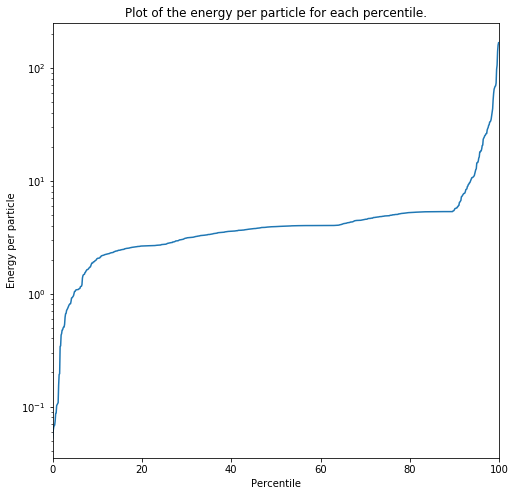

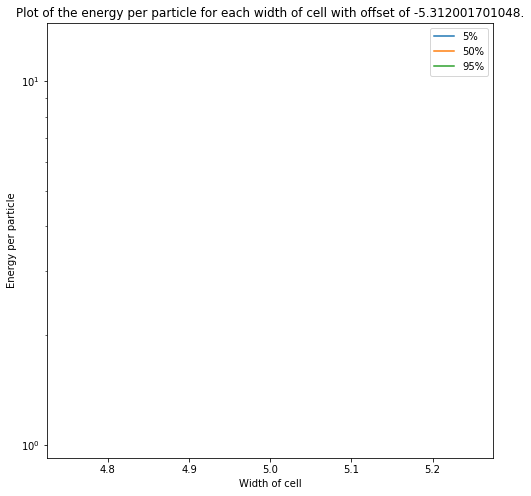

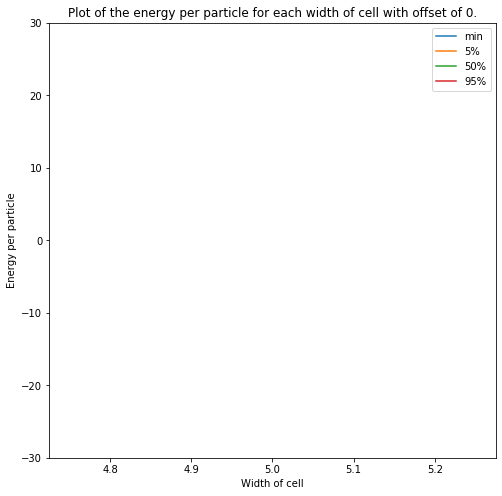

In [140]:

#"""
qLow = data['potentialEnergy'].quantile(0.01)
qHi  = data['potentialEnergy'].quantile(0.99)
dataFiltered = data.copy()
#dataFiltered = data[(data['potentialEnergy'] < qHi) & (data['potentialEnergy'] > qLow)]

x = dataFiltered['potentialEnergy']
fig, ax = plt.subplots(figsize=(8, 8))
sortedX = np.sort(x) - 1.01 * min(x)
ax.plot([100*i/len(x) for i in range(0, len(x))], sortedX)
ax.set_xlim(0, 100)
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each percentile.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Percentile')
plt.show()

#"""


#"""
tempData = dataFiltered.copy()
tempOfsett = 1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['5%', '50%', '95%'])
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""

#"""
tempData = dataFiltered.copy()
tempOfsett = 0#1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['min'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['min', '5%', '50%', '95%'])
plt.ylim(-30, 30)
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""


## Preparing data

In [141]:
#"""
trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

inputData = []
targetData = []
for i in trainingData.index:
    #inputData.append(np.array(trainingData['eigenvalues'][i]))
    inputData.append(np.array(trainingData['relativeDistances'][i]))
    targetData.append(trainingData['potentialEnergy'][i])
    #targetData.append(sum(trainingData['eigenvalues'][i]))
    #targetData.append([sum(trainingData['relativeDistances'][i])])

trainingInput = {'input':np.array(inputData), 'target':np.array(targetData)}

print('Results training input:')
[print(trainingInput['input'][i], trainingInput['target'][i], '\n') for i in range(0, 3)]
print(np.shape(trainingInput['input']))
print(type(trainingInput['input']))
print(type(trainingInput['input'][0]))
print(np.shape(trainingInput['target']))
print(type(trainingInput['target']))

inputData = []
targetData = []
for i in validationData.index:
    #inputData.append(np.array(validationData['eigenvalues'][i]))
    inputData.append(np.array(validationData['relativeDistances'][i]))
    targetData.append(validationData['potentialEnergy'][i])
    #targetData.append([sum(validationData['eigenvalues'][i])])
    #targetData.append([sum(validationData['relativeDistances'][i])])

validationInput = {'input':np.array(inputData), 'target':np.array(targetData)}

print('Results validation input:')
[print(validationInput['input'][i], validationInput['target'][i], '\n') for i in range(0, 3)]
print(np.shape(validationInput['input']))
print(type(validationInput['input']))
print(type(validationInput['input'][0]))
print(np.shape(validationInput['target']))
print(type(validationInput['target']))

validationPlots = [random.choice(validationData.index) for i in range(0, 11)]

#"""
print()

Results training input:
[5.00000000e+00 2.35940730e-03 2.07694016e+00 2.17326764e+00
 2.65811924e+00 2.80264924e+00 3.43941147e+00 1.14605200e-04
 2.99320164e+00 3.20383262e+00 4.33372839e+00 4.69194726e+00
 6.37861225e+00 5.56680000e-06 4.31368041e+00 4.72309222e+00
 7.06559790e+00 7.85484275e+00 1.18295512e+01] -2.3772463527 

[ 5.          0.19579737  1.10506074  1.44074049  1.58292733  2.18519415
  3.44935312  0.08663837  1.16166051  1.72933305  1.99155116  3.23024189
  6.40628838  0.03833661  1.22115925  2.07573315  2.50565893  4.77507349
 11.89803693] -2.9431665545000003 

[ 5.          0.635619    1.00188463  1.17073452  1.17900912  1.67357305
  4.20767955  0.5067518   1.00282827  1.26674044  1.28019389  2.16504542
  8.63105701  0.40401151  1.0037728   1.37061932  1.39006252  2.80084677
 17.70456717] -3.0133611206 

(720, 19)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(720,)
<class 'numpy.ndarray'>
Results validation input:
[5.00000000e+00 4.35552708e-01 7.70460874e-01 2.15

## Preparing test data

No handles with labels found to put in legend.


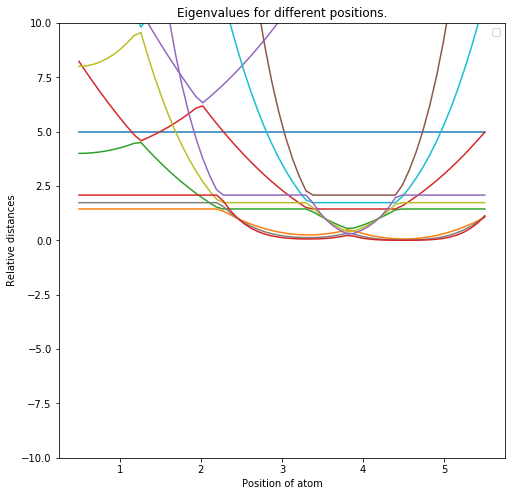

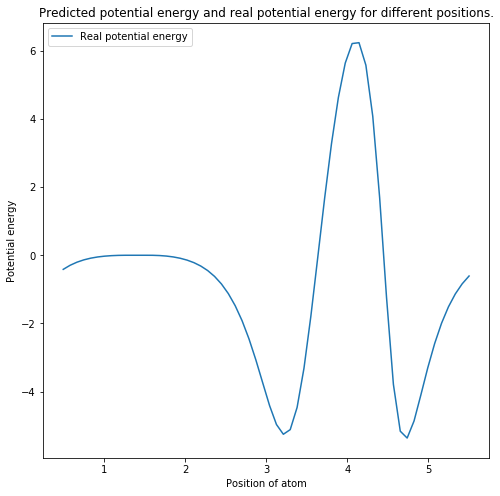

In [142]:
#"""
widthOfCell = 5.0
numberOfSurroundingCells = 3
R0 = 20
x = np.linspace(0.1, 1.1, 60)

testData = {'particleCoordinates': [],'widthOfCell':[] , 'numberOfSurroundingCells': [], 'potentialEnergy':[]}# Initialy use a dictionary because it's easier to append to than a dataframe.
for i in x:
    particles = [np.array([0.1, 0.1]), np.array([0.55, 0.9]), np.array([0.6, 0.665]), np.array([0.5, i])]
    particles = [widthOfCell * coordinate for coordinate in particles]
    otherSpace = generateSpace(particles, numberOfSurroundingCells, widthOfCell)# Generate the other space.
    testData['particleCoordinates'].append(particles)
    testData['widthOfCell'].append(widthOfCell)
    testData['numberOfSurroundingCells'].append(numberOfSurroundingCells)
    testData['potentialEnergy'].append(potentialEnergy(otherSpace, particles, potentialEnergyPerTrio) - offset)# Calculate the potential energy and save it to the data dictonairy.

x = widthOfCell * x
testData = prepareDatabseForMachineLearning(pd.DataFrame(testData), orderOfMatrix, R0, giveUpdates = False)

fig, ax1 = plt.subplots(figsize=(8, 8))
#ax1.plot(list(x), [testData['Eigenvalues'][i] for i in range(0, len(testData['Eigenvalues']))])
ax1.plot(list(x), [testData['relativeDistances'][i] for i in range(0, len(testData['relativeDistances']))])
ax1.legend()
ax1.set_ylim(-10, 10)
ax1.set_xlabel('Position of atom')
#ax1.set_ylabel('Eigenvalues')
ax1.set_ylabel('Relative distances')
ax1.set_title('Eigenvalues for different positions.')
plt.show()

testData.head()
testData.describe()

y = []
for i in range(len(x)):
    y.append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y, label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()
#"""
print()

# Machine learning

In [143]:
def RSMPE(target,value):
    return ((keras.backend.mean(((value-target)/target)**2))**0.5)*100

def MAE(target,value):
    return keras.backend.mean(abs(value-target))

models = []
prefixName = 0
saveFolder = 'testRun'
lossMetric = MAE#keras.losses.MeanAbsoluteError()#keras.losses.MeanSquaredError()
#trainNetwork(model, trainingInput, 0.3, numberOfEpochs=100, batchSize=32, verboseSetting=1)
#fitDetails = network.fit(trainingData[0], trainingData[1], shuffle=True, batch_size=batchSize, validation_split=validationSplit, epochs=numberOfEpochs, verbose=max(0,verboseSetting))


## Model 0: Linear network

In [144]:
name = 'LinearNetwork'
settingsLineaerNet = [['Dense', 1, 'linear', False]]
learningRate = 1*10**-4
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, min_delta=2*10**-1)]

model = makeDenseNetwork(inputSize, settingsLineaerNet, learningRate, kernalInitializer='he_uniform', lossFunction=MAE)
#model.layers[0].set_weights([np.array([[1] for i in range(inputSize)])])
#model.layers[0].set_weights([np.array([[random.uniform(0.5, 1.5)] for i in range(inputSize)])])


model.summary()
print(model.evaluate(validationInput['input'], validationInput['target'], verbose=1))
print(model.evaluate(trainingInput['input'], trainingInput['target'], verbose=1))
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 1)                 19        
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________
180/180 [==============================] - 0s 83us/step
252.1609659830729
720/720 [==============================] - 0s 32us/step
231.045901828342
Layer 0:  [array([[ 0.47658998],
       [ 0.15717518],
       [-0.15298858],
       [ 0.01555449],
       [ 0.2603284 ],
       [-0.04079908],
       [-0.49918425],
       [-0.48110747],
       [ 0.49494594],
       [ 0.03799462],
       [-0.2970174 ],
       [-0.14197639],
       [-0.15911639],
       [-0.5156738 ],
       [ 0.38714767],
       [-0.19191715],
       [-0.17937279],
       [-0.4952699 ],
       [-0.32666063]], dtype=float32)]


Train on 503 samples, validate on 217 samples
Epoch 1/1000
503/503 [==============================] - 0s 153us/step - loss: 225.2398 - val_loss: 241.7991
Epoch 2/1000
503/503 [==============================] - 0s 72us/step - loss: 223.9622 - val_loss: 240.4760
Epoch 3/1000
503/503 [==============================] - 0s 72us/step - loss: 222.7125 - val_loss: 239.1108
Epoch 4/1000
503/503 [==============================] - 0s 70us/step - loss: 221.4485 - val_loss: 237.7578
Epoch 5/1000
503/503 [==============================] - 0s 73us/step - loss: 220.1710 - val_loss: 236.4120
Epoch 6/1000
503/503 [==============================] - 0s 73us/step - loss: 218.9134 - val_loss: 235.0663
Epoch 7/1000
503/503 [==============================] - 0s 74us/step - loss: 217.6518 - val_loss: 233.7136
Epoch 8/1000
503/503 [==============================] - 0s 71us/step - loss: 216.3689 - val_loss: 232.3890
Epoch 9/1000
503/503 [==============================] - 0s 77us/step - loss: 215.1397 - val_loss:

503/503 [==============================] - 0s 69us/step - loss: 130.9392 - val_loss: 141.2068
Epoch 77/1000
503/503 [==============================] - 0s 69us/step - loss: 129.6794 - val_loss: 139.9077
Epoch 78/1000
503/503 [==============================] - 0s 72us/step - loss: 128.4471 - val_loss: 138.5857
Epoch 79/1000
503/503 [==============================] - 0s 67us/step - loss: 127.2094 - val_loss: 137.2658
Epoch 80/1000
503/503 [==============================] - 0s 66us/step - loss: 125.9680 - val_loss: 135.9571
Epoch 81/1000
503/503 [==============================] - 0s 70us/step - loss: 124.7553 - val_loss: 134.6162
Epoch 82/1000
503/503 [==============================] - 0s 68us/step - loss: 123.4979 - val_loss: 133.3103
Epoch 83/1000
503/503 [==============================] - 0s 67us/step - loss: 122.2956 - val_loss: 131.9618
Epoch 84/1000
503/503 [==============================] - 0s 68us/step - loss: 121.0381 - val_loss: 130.6664
Epoch 85/1000
503/503 [===================

503/503 [==============================] - 0s 76us/step - loss: 44.9137 - val_loss: 50.3225
Epoch 153/1000
503/503 [==============================] - 0s 85us/step - loss: 44.1256 - val_loss: 49.3863
Epoch 154/1000
503/503 [==============================] - 0s 82us/step - loss: 43.2942 - val_loss: 48.5015
Epoch 155/1000
503/503 [==============================] - 0s 84us/step - loss: 42.5036 - val_loss: 47.6013
Epoch 156/1000
503/503 [==============================] - 0s 78us/step - loss: 41.6888 - val_loss: 46.7774
Epoch 157/1000
503/503 [==============================] - 0s 84us/step - loss: 40.9751 - val_loss: 45.9252
Epoch 158/1000
503/503 [==============================] - 0s 92us/step - loss: 40.2414 - val_loss: 45.1332
Epoch 159/1000
503/503 [==============================] - 0s 81us/step - loss: 39.5693 - val_loss: 44.2915
Epoch 160/1000
503/503 [==============================] - 0s 90us/step - loss: 38.8449 - val_loss: 43.5261
Epoch 161/1000
503/503 [============================

503/503 [==============================] - 0s 76us/step - loss: 19.2001 - val_loss: 19.6425
Epoch 229/1000
503/503 [==============================] - 0s 71us/step - loss: 19.1272 - val_loss: 19.5685
Epoch 230/1000
503/503 [==============================] - 0s 74us/step - loss: 19.0568 - val_loss: 19.4960
Epoch 231/1000
503/503 [==============================] - 0s 76us/step - loss: 18.9868 - val_loss: 19.4256
Epoch 232/1000
503/503 [==============================] - 0s 69us/step - loss: 18.9168 - val_loss: 19.3544
Epoch 233/1000
503/503 [==============================] - 0s 75us/step - loss: 18.8482 - val_loss: 19.2893
Epoch 234/1000
503/503 [==============================] - 0s 75us/step - loss: 18.7771 - val_loss: 19.2167
Epoch 235/1000
503/503 [==============================] - 0s 74us/step - loss: 18.7055 - val_loss: 19.1530
Epoch 236/1000
503/503 [==============================] - 0s 76us/step - loss: 18.6350 - val_loss: 19.0884
Epoch 237/1000
503/503 [============================

503/503 [==============================] - 0s 71us/step - loss: 14.5257 - val_loss: 15.1789
Epoch 305/1000
503/503 [==============================] - 0s 74us/step - loss: 14.4743 - val_loss: 15.1375
Epoch 306/1000
503/503 [==============================] - 0s 72us/step - loss: 14.4205 - val_loss: 15.0937
Epoch 307/1000
503/503 [==============================] - 0s 77us/step - loss: 14.3616 - val_loss: 15.0303
Epoch 308/1000
503/503 [==============================] - 0s 73us/step - loss: 14.3068 - val_loss: 14.9773
Epoch 309/1000
503/503 [==============================] - 0s 69us/step - loss: 14.2569 - val_loss: 14.9130
Epoch 310/1000
503/503 [==============================] - 0s 75us/step - loss: 14.2034 - val_loss: 14.8625
Epoch 311/1000
503/503 [==============================] - 0s 76us/step - loss: 14.1522 - val_loss: 14.8246
Epoch 312/1000
503/503 [==============================] - 0s 76us/step - loss: 14.0997 - val_loss: 14.7708
Epoch 313/1000
503/503 [============================

503/503 [==============================] - 0s 72us/step - loss: 11.1032 - val_loss: 11.6488
Epoch 381/1000
503/503 [==============================] - 0s 71us/step - loss: 11.0679 - val_loss: 11.5998
Epoch 382/1000
503/503 [==============================] - 0s 73us/step - loss: 11.0303 - val_loss: 11.5646
Epoch 383/1000
503/503 [==============================] - 0s 73us/step - loss: 10.9869 - val_loss: 11.5147
Epoch 384/1000
503/503 [==============================] - 0s 72us/step - loss: 10.9488 - val_loss: 11.4739
Epoch 385/1000
503/503 [==============================] - 0s 70us/step - loss: 10.9062 - val_loss: 11.4266
Epoch 386/1000
503/503 [==============================] - 0s 72us/step - loss: 10.8651 - val_loss: 11.3852
Epoch 387/1000
503/503 [==============================] - 0s 71us/step - loss: 10.8273 - val_loss: 11.3439
Epoch 388/1000
503/503 [==============================] - 0s 69us/step - loss: 10.7883 - val_loss: 11.3063
Epoch 389/1000
503/503 [============================

503/503 [==============================] - 0s 80us/step - loss: 8.1538 - val_loss: 8.5007
Epoch 458/1000
503/503 [==============================] - 0s 84us/step - loss: 8.1208 - val_loss: 8.4699
Epoch 459/1000
503/503 [==============================] - 0s 85us/step - loss: 8.0853 - val_loss: 8.4253
Epoch 460/1000
503/503 [==============================] - 0s 77us/step - loss: 8.0496 - val_loss: 8.3899
Epoch 461/1000
503/503 [==============================] - 0s 77us/step - loss: 8.0161 - val_loss: 8.3548
Epoch 462/1000
503/503 [==============================] - 0s 82us/step - loss: 7.9917 - val_loss: 8.3286
Epoch 463/1000
503/503 [==============================] - 0s 78us/step - loss: 7.9523 - val_loss: 8.2688
Epoch 464/1000
503/503 [==============================] - 0s 78us/step - loss: 7.9133 - val_loss: 8.2272
Epoch 465/1000
503/503 [==============================] - 0s 74us/step - loss: 7.8793 - val_loss: 8.1978
Epoch 466/1000
503/503 [==============================] - 0s 72us/step

503/503 [==============================] - 0s 69us/step - loss: 5.6784 - val_loss: 5.8000
Epoch 536/1000
503/503 [==============================] - 0s 68us/step - loss: 5.6458 - val_loss: 5.7324
Epoch 537/1000
503/503 [==============================] - 0s 69us/step - loss: 5.6187 - val_loss: 5.6907
Epoch 538/1000
503/503 [==============================] - 0s 77us/step - loss: 5.5880 - val_loss: 5.6567
Epoch 539/1000
503/503 [==============================] - 0s 70us/step - loss: 5.5627 - val_loss: 5.6420
Epoch 540/1000
503/503 [==============================] - 0s 74us/step - loss: 5.5321 - val_loss: 5.5947
Epoch 541/1000
503/503 [==============================] - 0s 70us/step - loss: 5.5050 - val_loss: 5.5747
Epoch 542/1000
503/503 [==============================] - 0s 72us/step - loss: 5.4787 - val_loss: 5.5199
Epoch 543/1000
503/503 [==============================] - 0s 75us/step - loss: 5.4504 - val_loss: 5.5055
Epoch 544/1000
503/503 [==============================] - 0s 69us/step

503/503 [==============================] - 0s 74us/step - loss: 3.9414 - val_loss: 3.9145
Epoch 614/1000
503/503 [==============================] - 0s 71us/step - loss: 3.9308 - val_loss: 3.9052
Epoch 615/1000
503/503 [==============================] - 0s 80us/step - loss: 3.9222 - val_loss: 3.8856
Epoch 616/1000
503/503 [==============================] - 0s 78us/step - loss: 3.9094 - val_loss: 3.8729
Epoch 617/1000
503/503 [==============================] - 0s 77us/step - loss: 3.8939 - val_loss: 3.8559
Epoch 618/1000
503/503 [==============================] - 0s 73us/step - loss: 3.8840 - val_loss: 3.8383
Epoch 619/1000
503/503 [==============================] - 0s 89us/step - loss: 3.8706 - val_loss: 3.8319
Epoch 620/1000
503/503 [==============================] - 0s 106us/step - loss: 3.8613 - val_loss: 3.8089
Epoch 621/1000
503/503 [==============================] - 0s 71us/step - loss: 3.8495 - val_loss: 3.7879
Epoch 622/1000
503/503 [==============================] - 0s 274us/st

503/503 [==============================] - 0s 64us/step - loss: 3.3508 - val_loss: 3.2884
Epoch 692/1000
503/503 [==============================] - 0s 64us/step - loss: 3.3379 - val_loss: 3.2854
Epoch 693/1000
503/503 [==============================] - 0s 63us/step - loss: 3.3375 - val_loss: 3.2827
Epoch 694/1000
503/503 [==============================] - 0s 73us/step - loss: 3.3344 - val_loss: 3.2801
Epoch 695/1000
503/503 [==============================] - 0s 67us/step - loss: 3.3362 - val_loss: 3.2901
Epoch 696/1000
503/503 [==============================] - 0s 71us/step - loss: 3.3290 - val_loss: 3.2673
Epoch 697/1000
503/503 [==============================] - 0s 66us/step - loss: 3.3319 - val_loss: 3.2892
Epoch 698/1000
503/503 [==============================] - 0s 69us/step - loss: 3.3317 - val_loss: 3.2621
Epoch 699/1000
503/503 [==============================] - 0s 64us/step - loss: 3.3229 - val_loss: 3.2785
Epoch 700/1000
503/503 [==============================] - 0s 67us/step

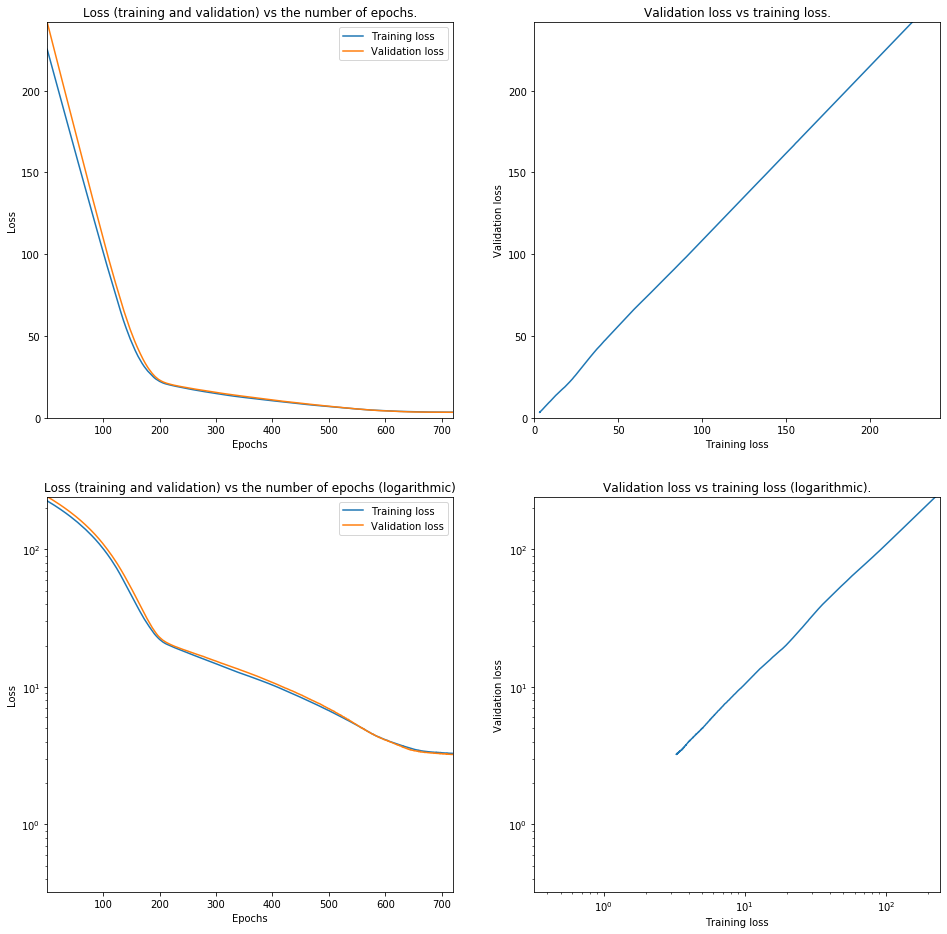

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 1)                 19        
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________
2.9460541831122504
Layer 0:  [array([[-0.04581847],
       [ 0.29340735],
       [-0.5324224 ],
       [-0.01836509],
       [ 0.23424266],
       [ 0.04433036],
       [-0.5222038 ],
       [-0.1401595 ],
       [ 0.12666039],
       [ 0.1675241 ],
       [-0.16856462],
       [ 0.18624346],
       [ 0.0383649 ],
       [-0.12871645],
       [ 0.00911594],
       [-0.03684924],
       [ 0.02379604],
       [-0.03483649],
       [ 0.00788467]], dtype=float32)]


In [145]:
fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=1000, verbose=1, callbacks=callbacksNetwork)

history = plotHistory(fitDetails)

evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

model.summary()
print(evaluation)
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

2.9460541831122504


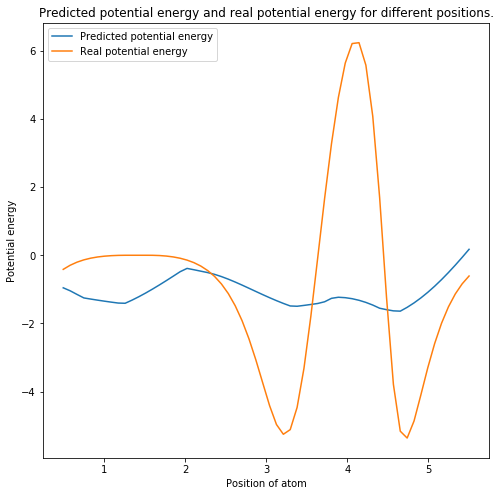

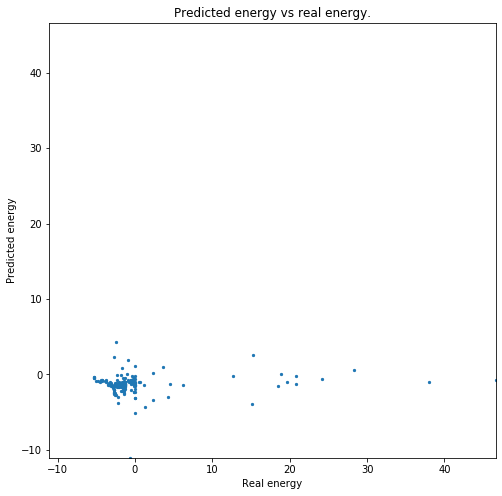

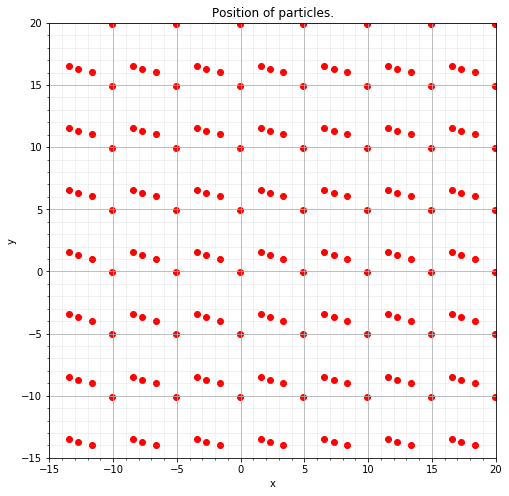

For index 754 Predicted -1.0555383 was -0.5771143634


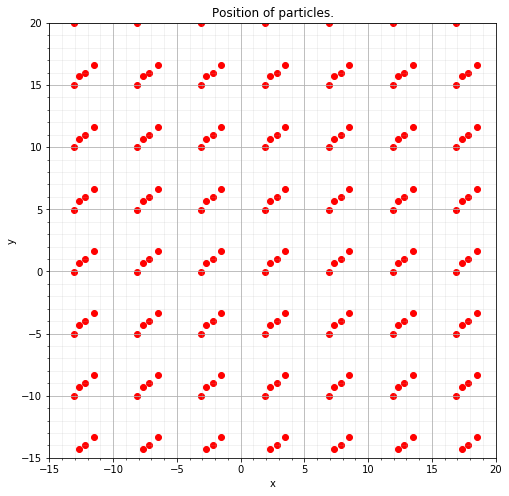

For index 35 Predicted -1.2174221 was -2.0393180157


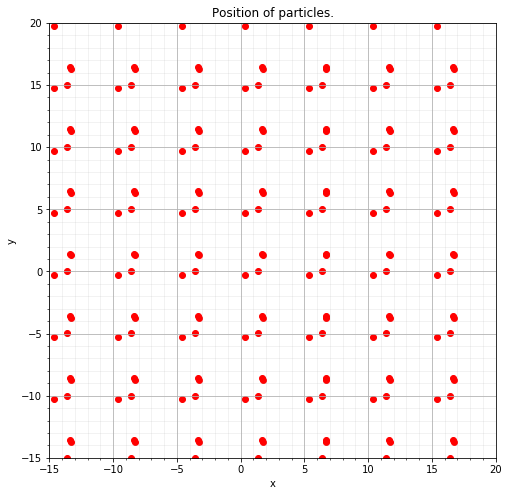

For index 354 Predicted -1.3874534 was -1.5862047633


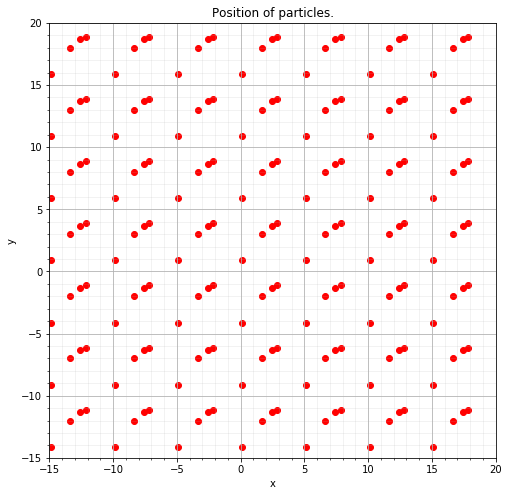

For index 788 Predicted -1.031102 was -1.3044599910999999


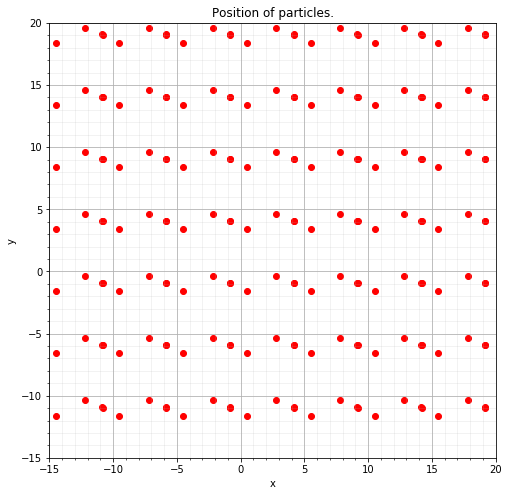

For index 278 Predicted -1.1158595 was -2.1899504979


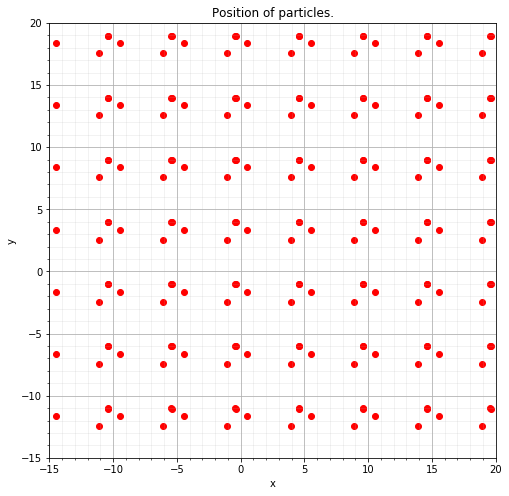

For index 142 Predicted -1.5659301 was 18.4494989008


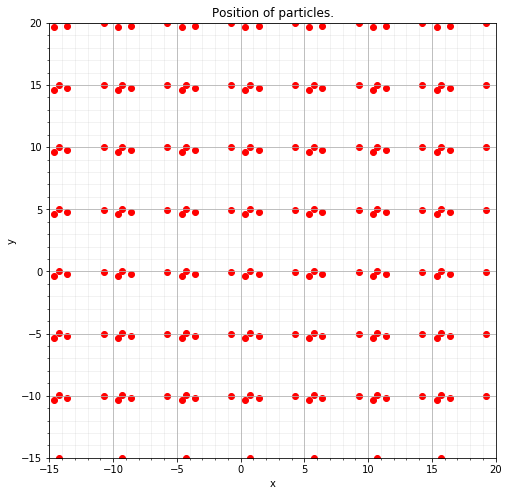

For index 548 Predicted 2.544159 was 15.2344832435


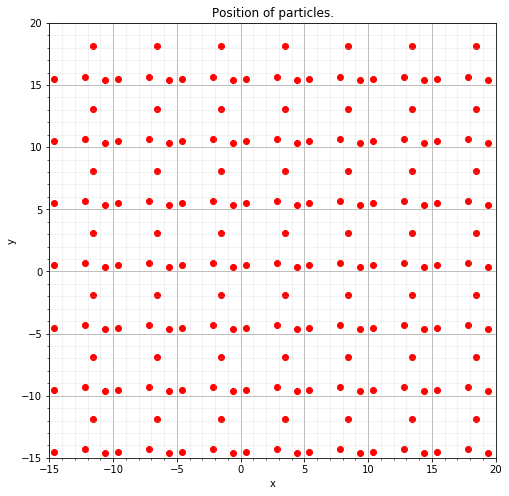

For index 517 Predicted -1.4659902 was -0.018872065900000002


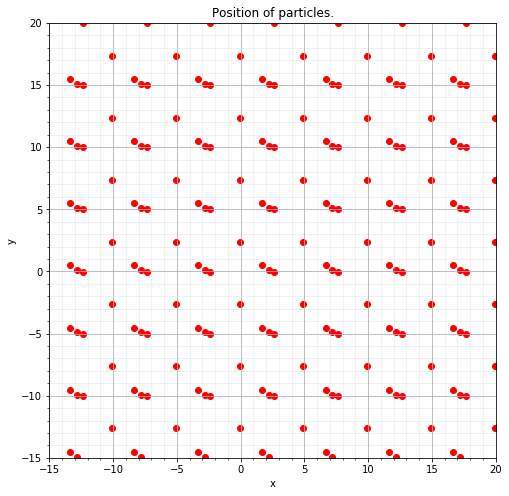

For index 583 Predicted 0.5673795 was 28.3504423379


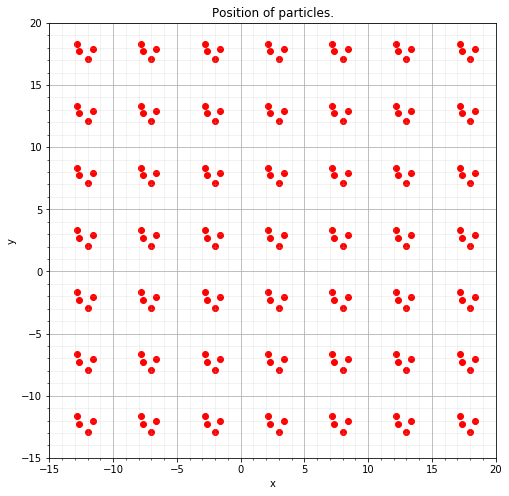

For index 336 Predicted -0.9711934 was -4.4591292936


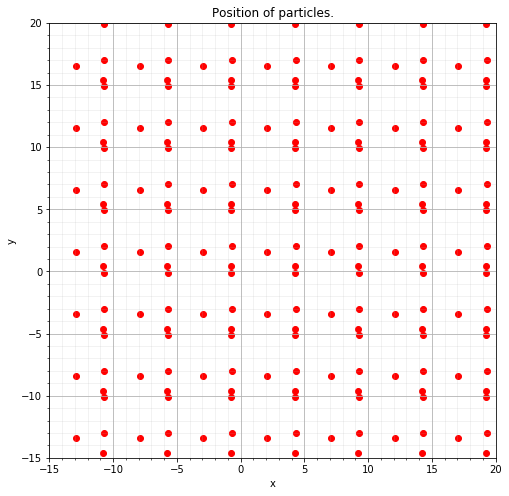

For index 657 Predicted -1.5012969 was -0.1619672391


In [146]:
print(evaluation)

y = [[],[]]
for i in range(len(x)):
    #y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[0].append(model.predict([[testData['relativeDistances'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
plt.show()

makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

## Model 1: 1 Dense layer

In [147]:
name = 'OneDenseLayer'
settingsLineaerNet = [['Dense', 128, 'softplus', False],['Dense', 1, 'linear', False]]
learningRate = 1*10**-5
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, min_delta=2*10**-1)]

model = makeDenseNetwork(inputSize, settingsLineaerNet, learningRate, kernalInitializer='he_uniform', lossFunction=MAE)

model.summary()
print(model.evaluate(validationInput['input'], validationInput['target'], verbose=1))
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 128)               2432      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 128       
Total params: 2,560
Trainable params: 2,560
Non-trainable params: 0
_________________________________________________________________
180/180 [==============================] - 0s 106us/step
423.8622043185764
Layer 0:  [array([[-0.39737955, -0.22547922,  0.3967355 , ...,  0.16905701,
         0.14115   , -0.466365  ],
       [-0.46214652,  0.17291766,  0.11483663, ..., -0.07515964,
         0.37220317,  0.45259267],
       [ 0.46011788,  0.3273098 , -0.15436414, ...,  0.21003419,
        -0.26348856, -0.5517706 ],
       ...,
       [-0.17270476,  0.20681185,  0.36403805, ...,  0.10947639,
         0.3359844 , -0.18253323],
       [-0.4723

Train on 503 samples, validate on 217 samples
Epoch 1/1000
503/503 [==============================] - 0s 258us/step - loss: 384.8548 - val_loss: 401.0891
Epoch 2/1000
503/503 [==============================] - 0s 84us/step - loss: 382.8802 - val_loss: 398.8638
Epoch 3/1000
503/503 [==============================] - 0s 75us/step - loss: 380.7579 - val_loss: 396.7549
Epoch 4/1000
503/503 [==============================] - 0s 70us/step - loss: 378.6979 - val_loss: 394.6214
Epoch 5/1000
503/503 [==============================] - 0s 74us/step - loss: 376.7035 - val_loss: 392.4192
Epoch 6/1000
503/503 [==============================] - 0s 88us/step - loss: 374.6530 - val_loss: 390.2361
Epoch 7/1000
503/503 [==============================] - 0s 73us/step - loss: 372.6366 - val_loss: 388.0439
Epoch 8/1000
503/503 [==============================] - 0s 76us/step - loss: 370.5956 - val_loss: 385.8869
Epoch 9/1000
503/503 [==============================] - 0s 74us/step - loss: 368.5471 - val_loss:

503/503 [==============================] - 0s 84us/step - loss: 233.9174 - val_loss: 240.9277
Epoch 77/1000
503/503 [==============================] - 0s 90us/step - loss: 231.8757 - val_loss: 238.8300
Epoch 78/1000
503/503 [==============================] - 0s 82us/step - loss: 229.9215 - val_loss: 236.6758
Epoch 79/1000
503/503 [==============================] - 0s 74us/step - loss: 227.8850 - val_loss: 234.5844
Epoch 80/1000
503/503 [==============================] - 0s 74us/step - loss: 225.8858 - val_loss: 232.4816
Epoch 81/1000
503/503 [==============================] - 0s 81us/step - loss: 223.9380 - val_loss: 230.3013
Epoch 82/1000
503/503 [==============================] - 0s 83us/step - loss: 221.8859 - val_loss: 228.2108
Epoch 83/1000
503/503 [==============================] - 0s 78us/step - loss: 219.8849 - val_loss: 226.1269
Epoch 84/1000
503/503 [==============================] - 0s 87us/step - loss: 217.9161 - val_loss: 224.0088
Epoch 85/1000
503/503 [===================

503/503 [==============================] - 0s 83us/step - loss: 83.9330 - val_loss: 82.3881
Epoch 152/1000
503/503 [==============================] - 0s 82us/step - loss: 81.9285 - val_loss: 80.3373
Epoch 153/1000
503/503 [==============================] - 0s 71us/step - loss: 79.9358 - val_loss: 78.3199
Epoch 154/1000
503/503 [==============================] - 0s 85us/step - loss: 77.9853 - val_loss: 76.2832
Epoch 155/1000
503/503 [==============================] - 0s 72us/step - loss: 75.9714 - val_loss: 74.4107
Epoch 156/1000
503/503 [==============================] - 0s 82us/step - loss: 74.1146 - val_loss: 72.4628
Epoch 157/1000
503/503 [==============================] - 0s 77us/step - loss: 72.2338 - val_loss: 70.5357
Epoch 158/1000
503/503 [==============================] - 0s 80us/step - loss: 70.3620 - val_loss: 68.6426
Epoch 159/1000
503/503 [==============================] - 0s 80us/step - loss: 68.5073 - val_loss: 66.7612
Epoch 160/1000
503/503 [============================

503/503 [==============================] - 0s 65us/step - loss: 25.3714 - val_loss: 23.9992
Epoch 228/1000
503/503 [==============================] - 0s 71us/step - loss: 25.2612 - val_loss: 23.8986
Epoch 229/1000
503/503 [==============================] - 0s 104us/step - loss: 25.1564 - val_loss: 23.7967
Epoch 230/1000
503/503 [==============================] - 0s 82us/step - loss: 25.0414 - val_loss: 23.6969
Epoch 231/1000
503/503 [==============================] - 0s 82us/step - loss: 24.9273 - val_loss: 23.6030
Epoch 232/1000
503/503 [==============================] - 0s 77us/step - loss: 24.8168 - val_loss: 23.5059
Epoch 233/1000
503/503 [==============================] - 0s 64us/step - loss: 24.7060 - val_loss: 23.4049
Epoch 234/1000
503/503 [==============================] - 0s 65us/step - loss: 24.5948 - val_loss: 23.3032
Epoch 235/1000
503/503 [==============================] - 0s 65us/step - loss: 24.4815 - val_loss: 23.2064
Epoch 236/1000
503/503 [===========================

503/503 [==============================] - 0s 91us/step - loss: 16.8610 - val_loss: 16.8384
Epoch 304/1000
503/503 [==============================] - 0s 95us/step - loss: 16.7580 - val_loss: 16.7510
Epoch 305/1000
503/503 [==============================] - 0s 92us/step - loss: 16.6603 - val_loss: 16.6620
Epoch 306/1000
503/503 [==============================] - 0s 97us/step - loss: 16.5563 - val_loss: 16.5725
Epoch 307/1000
503/503 [==============================] - 0s 98us/step - loss: 16.4570 - val_loss: 16.4862
Epoch 308/1000
503/503 [==============================] - 0s 101us/step - loss: 16.3578 - val_loss: 16.3950
Epoch 309/1000
503/503 [==============================] - 0s 78us/step - loss: 16.2551 - val_loss: 16.3066
Epoch 310/1000
503/503 [==============================] - 0s 76us/step - loss: 16.1534 - val_loss: 16.2179
Epoch 311/1000
503/503 [==============================] - 0s 75us/step - loss: 16.0569 - val_loss: 16.1250
Epoch 312/1000
503/503 [===========================

503/503 [==============================] - 0s 70us/step - loss: 10.1194 - val_loss: 10.6680
Epoch 380/1000
503/503 [==============================] - 0s 73us/step - loss: 10.0788 - val_loss: 10.6163
Epoch 381/1000
503/503 [==============================] - 0s 78us/step - loss: 9.9979 - val_loss: 10.5575
Epoch 382/1000
503/503 [==============================] - 0s 72us/step - loss: 9.9379 - val_loss: 10.5084
Epoch 383/1000
503/503 [==============================] - 0s 77us/step - loss: 9.8834 - val_loss: 10.4559
Epoch 384/1000
503/503 [==============================] - 0s 73us/step - loss: 9.8333 - val_loss: 10.4027
Epoch 385/1000
503/503 [==============================] - 0s 76us/step - loss: 9.7685 - val_loss: 10.3529
Epoch 386/1000
503/503 [==============================] - 0s 76us/step - loss: 9.7169 - val_loss: 10.3026
Epoch 387/1000
503/503 [==============================] - 0s 76us/step - loss: 9.6701 - val_loss: 10.2516
Epoch 388/1000
503/503 [==============================] - 0

503/503 [==============================] - 0s 67us/step - loss: 7.2145 - val_loss: 7.7263
Epoch 458/1000
503/503 [==============================] - 0s 68us/step - loss: 7.1979 - val_loss: 7.6992
Epoch 459/1000
503/503 [==============================] - 0s 66us/step - loss: 7.1751 - val_loss: 7.6750
Epoch 460/1000
503/503 [==============================] - 0s 67us/step - loss: 7.1500 - val_loss: 7.6505
Epoch 461/1000
503/503 [==============================] - 0s 66us/step - loss: 7.1351 - val_loss: 7.6245
Epoch 462/1000
503/503 [==============================] - 0s 66us/step - loss: 7.1124 - val_loss: 7.5987
Epoch 463/1000
503/503 [==============================] - 0s 67us/step - loss: 7.0941 - val_loss: 7.5729
Epoch 464/1000
503/503 [==============================] - 0s 70us/step - loss: 7.0707 - val_loss: 7.5485
Epoch 465/1000
503/503 [==============================] - 0s 68us/step - loss: 7.0518 - val_loss: 7.5254
Epoch 466/1000
503/503 [==============================] - 0s 68us/step

503/503 [==============================] - 0s 64us/step - loss: 5.9638 - val_loss: 6.3007
Epoch 536/1000
503/503 [==============================] - 0s 64us/step - loss: 5.9588 - val_loss: 6.2692
Epoch 537/1000
503/503 [==============================] - 0s 66us/step - loss: 5.9400 - val_loss: 6.2525
Epoch 538/1000
503/503 [==============================] - 0s 68us/step - loss: 5.9273 - val_loss: 6.2430
Epoch 539/1000
503/503 [==============================] - 0s 65us/step - loss: 5.9113 - val_loss: 6.2277
Epoch 540/1000
503/503 [==============================] - 0s 68us/step - loss: 5.9015 - val_loss: 6.2142
Epoch 541/1000
503/503 [==============================] - 0s 64us/step - loss: 5.8868 - val_loss: 6.2032
Epoch 542/1000
503/503 [==============================] - 0s 64us/step - loss: 5.8772 - val_loss: 6.1919
Epoch 543/1000
503/503 [==============================] - 0s 66us/step - loss: 5.8642 - val_loss: 6.1763
Epoch 544/1000
503/503 [==============================] - 0s 68us/step

503/503 [==============================] - 0s 67us/step - loss: 5.1786 - val_loss: 5.4203
Epoch 614/1000
503/503 [==============================] - 0s 66us/step - loss: 5.1705 - val_loss: 5.4053
Epoch 615/1000
503/503 [==============================] - 0s 64us/step - loss: 5.1616 - val_loss: 5.4001
Epoch 616/1000
503/503 [==============================] - 0s 68us/step - loss: 5.1573 - val_loss: 5.3911
Epoch 617/1000
503/503 [==============================] - 0s 66us/step - loss: 5.1566 - val_loss: 5.3838
Epoch 618/1000
503/503 [==============================] - 0s 66us/step - loss: 5.1377 - val_loss: 5.3742
Epoch 619/1000
503/503 [==============================] - 0s 68us/step - loss: 5.1298 - val_loss: 5.3759
Epoch 620/1000
503/503 [==============================] - 0s 67us/step - loss: 5.1246 - val_loss: 5.3618
Epoch 621/1000
503/503 [==============================] - 0s 72us/step - loss: 5.1188 - val_loss: 5.3527
Epoch 622/1000
503/503 [==============================] - 0s 67us/step

503/503 [==============================] - 0s 76us/step - loss: 4.6650 - val_loss: 4.8938
Epoch 692/1000
503/503 [==============================] - 0s 72us/step - loss: 4.6488 - val_loss: 4.8978
Epoch 693/1000
503/503 [==============================] - 0s 71us/step - loss: 4.6424 - val_loss: 4.8843
Epoch 694/1000
503/503 [==============================] - 0s 71us/step - loss: 4.6604 - val_loss: 4.8953
Epoch 695/1000
503/503 [==============================] - 0s 68us/step - loss: 4.6399 - val_loss: 4.8721
Epoch 696/1000
503/503 [==============================] - 0s 75us/step - loss: 4.6273 - val_loss: 4.8763
Epoch 697/1000
503/503 [==============================] - 0s 71us/step - loss: 4.6377 - val_loss: 4.8614
Epoch 698/1000
503/503 [==============================] - 0s 70us/step - loss: 4.6144 - val_loss: 4.8598
Epoch 699/1000
503/503 [==============================] - 0s 71us/step - loss: 4.6078 - val_loss: 4.8497
Epoch 700/1000
503/503 [==============================] - 0s 73us/step

Epoch 769/1000
503/503 [==============================] - 0s 69us/step - loss: 4.2328 - val_loss: 4.5306
Epoch 770/1000
503/503 [==============================] - 0s 71us/step - loss: 4.2319 - val_loss: 4.5204
Epoch 771/1000
503/503 [==============================] - 0s 67us/step - loss: 4.2395 - val_loss: 4.5229
Epoch 772/1000
503/503 [==============================] - 0s 66us/step - loss: 4.2374 - val_loss: 4.5244
Epoch 773/1000
503/503 [==============================] - 0s 68us/step - loss: 4.2245 - val_loss: 4.5056
Epoch 774/1000
503/503 [==============================] - 0s 71us/step - loss: 4.2141 - val_loss: 4.5090
Epoch 775/1000
503/503 [==============================] - 0s 71us/step - loss: 4.2039 - val_loss: 4.5085
Epoch 776/1000
503/503 [==============================] - 0s 78us/step - loss: 4.2081 - val_loss: 4.4975
Epoch 777/1000
503/503 [==============================] - 0s 67us/step - loss: 4.1942 - val_loss: 4.5048
Epoch 778/1000
503/503 [==============================]

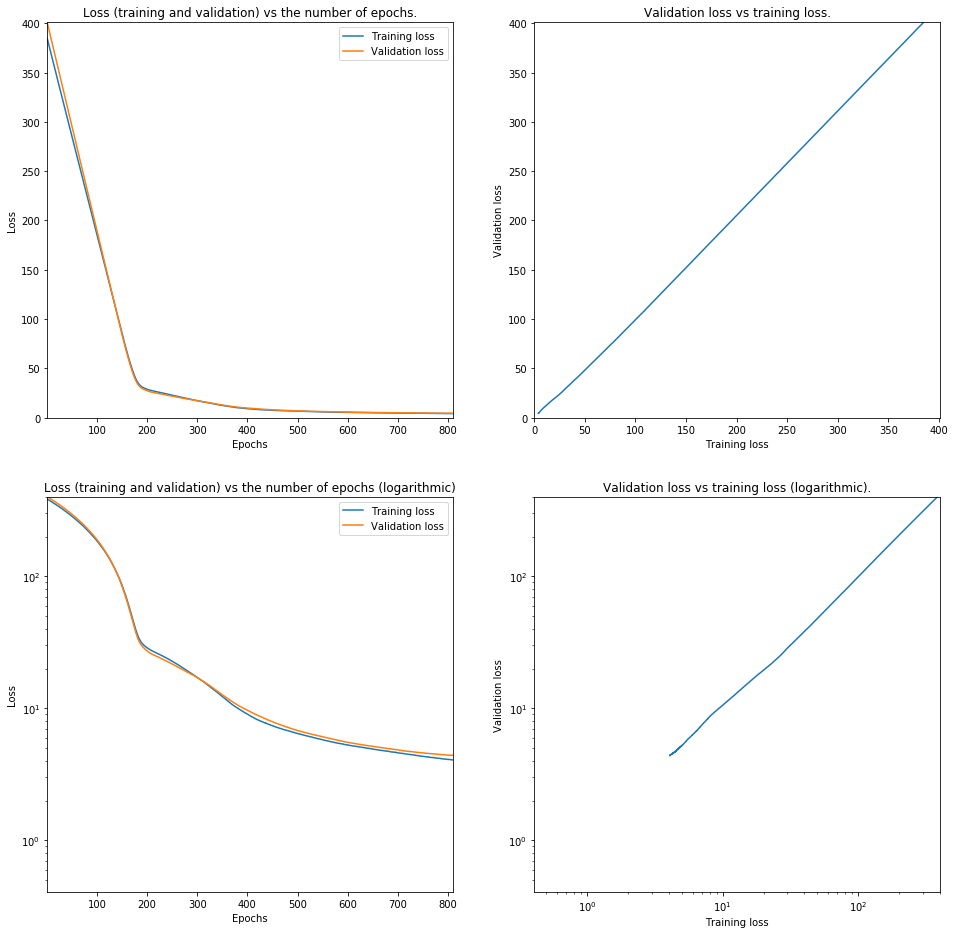

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 128)               2432      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 128       
Total params: 2,560
Trainable params: 2,560
Non-trainable params: 0
_________________________________________________________________
3.4292912165323894
Layer 0:  [array([[-0.29306293, -0.10994986,  0.45809248, ...,  0.14972204,
         0.18538341, -0.492663  ],
       [-0.341963  ,  0.2992943 ,  0.17278017, ..., -0.06255622,
         0.39214456,  0.41000614],
       [ 0.5129354 ,  0.41646665, -0.14461623, ...,  0.22636324,
        -0.27638164, -0.5775468 ],
       ...,
       [-0.12349147,  0.26734546,  0.3566356 , ...,  0.12796064,
         0.36398166, -0.21124339],
       [-0.39368248,  0.24781816,  0.29079515, ...,  0.22568564,
      

In [148]:
fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=1000, verbose=1, callbacks=callbacksNetwork)

history = plotHistory(fitDetails)

evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

model.summary()
print(evaluation)
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

3.4292912165323894


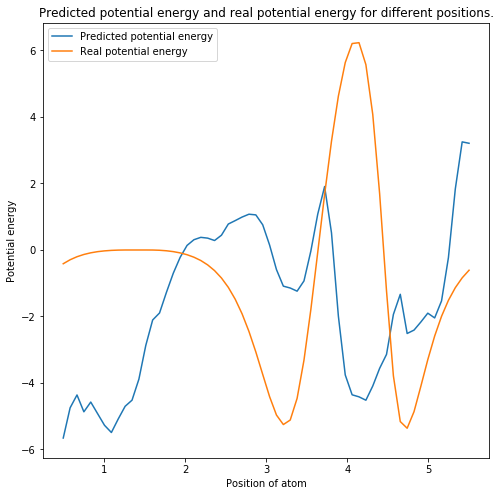

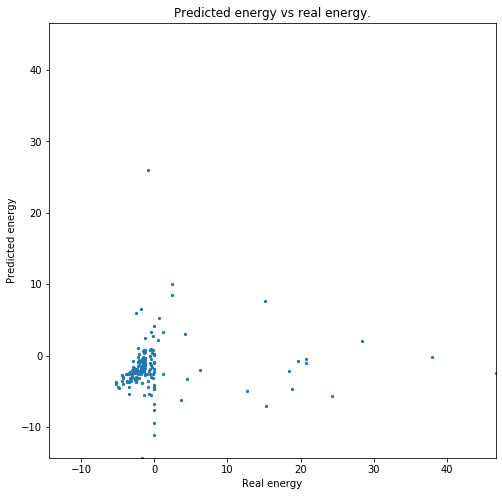

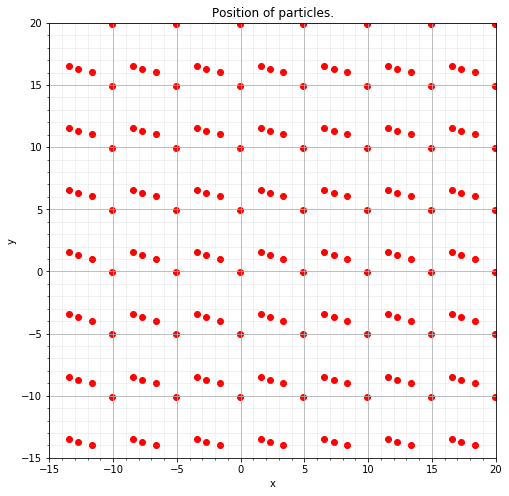

For index 754 Predicted -2.5282373 was -0.5771143634


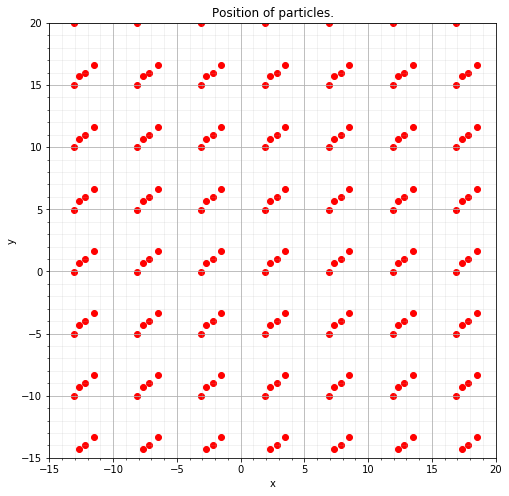

For index 35 Predicted -2.2347193 was -2.0393180157


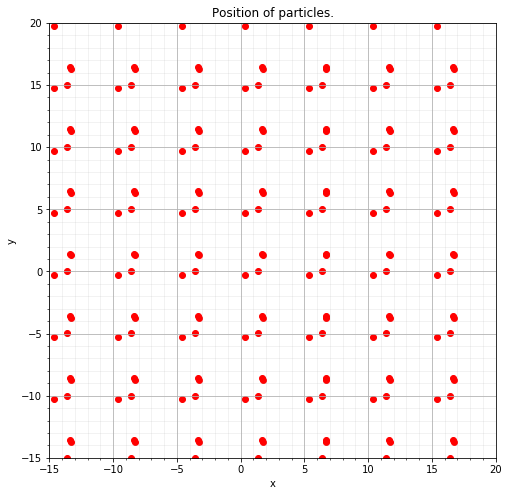

For index 354 Predicted 0.6759596 was -1.5862047633


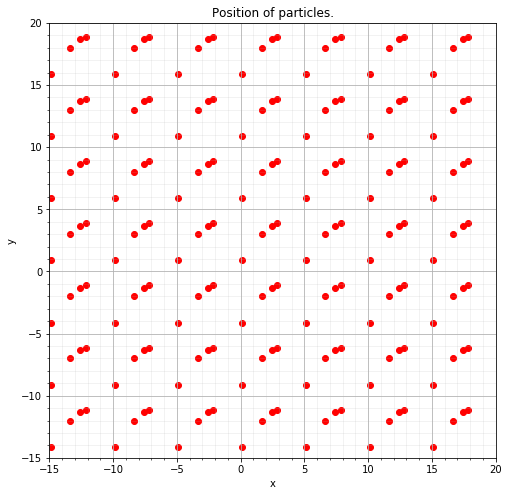

For index 788 Predicted 0.7534468 was -1.3044599910999999


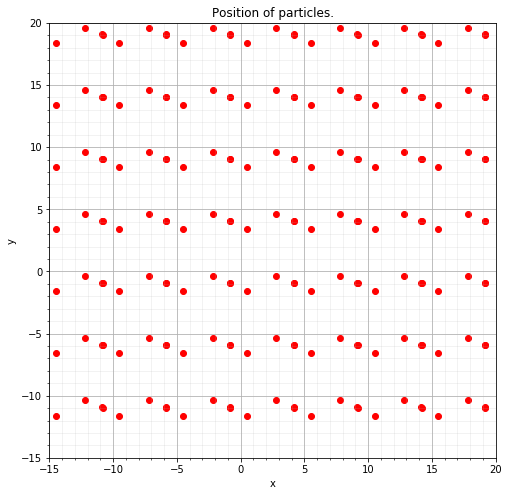

For index 278 Predicted -0.20342457 was -2.1899504979


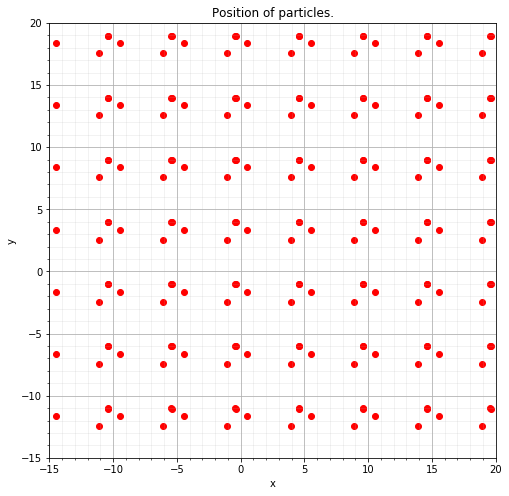

For index 142 Predicted -2.2107792 was 18.4494989008


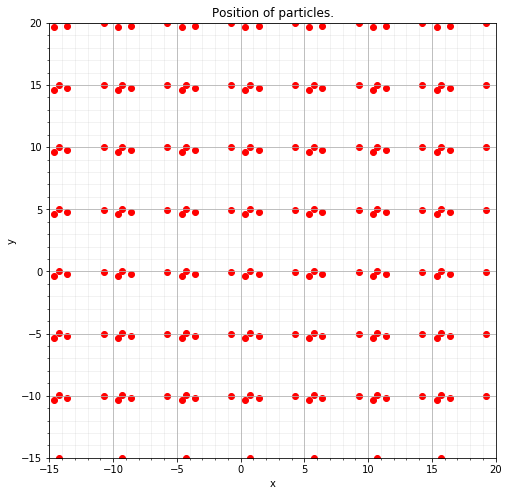

For index 548 Predicted -7.096047 was 15.2344832435


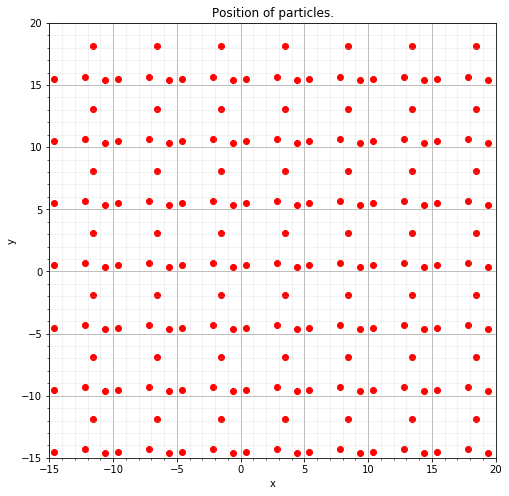

For index 517 Predicted -7.690956 was -0.018872065900000002


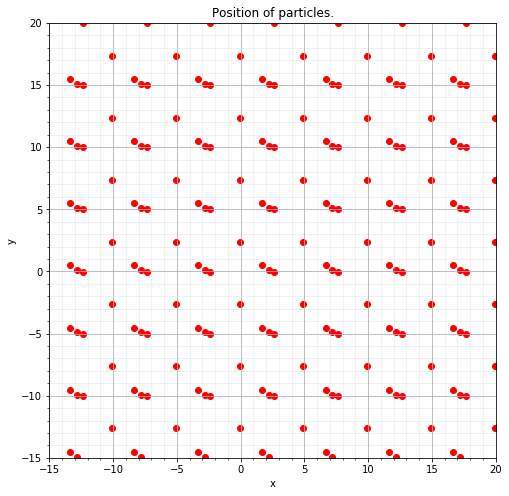

For index 583 Predicted 2.0942965 was 28.3504423379


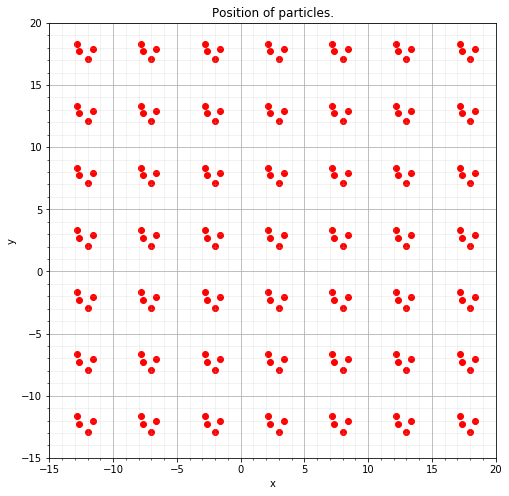

For index 336 Predicted -3.5184424 was -4.4591292936


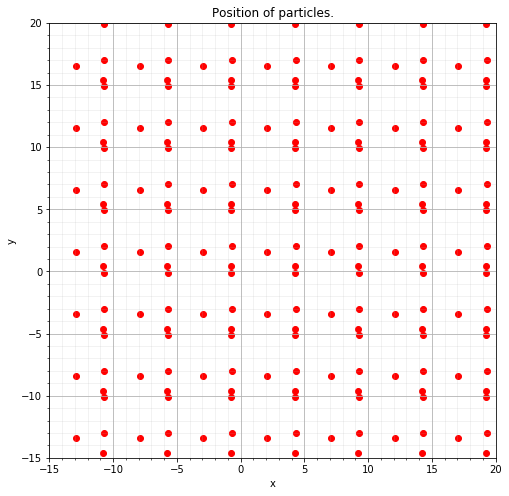

For index 657 Predicted -3.1997848 was -0.1619672391


In [149]:
print(evaluation)

y = [[],[]]
for i in range(len(x)):
    #y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[0].append(model.predict([[testData['relativeDistances'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
plt.show()

makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

## Model 2: 2 Dense layer

In [150]:
name = 'OneDenseLayer'
settingsLineaerNet = [['Dense', 128, 'softplus', False], ['Dense', 128, 'softplus', False],['Dense', 1, 'linear', False]]
learningRate = 1*10**-5
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, min_delta=2*10**-1)]

model = makeDenseNetwork(inputSize, settingsLineaerNet, learningRate, kernalInitializer='he_uniform', lossFunction=MAE)

model.summary()
print(model.evaluate(validationInput['input'], validationInput['target'], verbose=1))
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 128)               2432      
_________________________________________________________________
dense_31 (Dense)             (None, 128)               16384     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 128       
Total params: 18,944
Trainable params: 18,944
Non-trainable params: 0
_________________________________________________________________
180/180 [==============================] - 0s 100us/step
19.41454645792643
Layer 0:  [array([[ 0.2630356 , -0.12503734, -0.35954905, ..., -0.3541822 ,
         0.26521045,  0.34167308],
       [-0.35234094,  0.07507378,  0.01327765, ..., -0.3097867 ,
         0.10471755,  0.46373945],
       [ 0.27434105, -0.37748837,  0.4081338 , ...,  0.38481987,
        -0.47619295, -0.2646

Train on 503 samples, validate on 217 samples
Epoch 1/1000
503/503 [==============================] - 0s 196us/step - loss: 17.4600 - val_loss: 18.0769
Epoch 2/1000
503/503 [==============================] - 0s 70us/step - loss: 16.6831 - val_loss: 17.2513
Epoch 3/1000
503/503 [==============================] - 0s 72us/step - loss: 16.1750 - val_loss: 16.8296
Epoch 4/1000
503/503 [==============================] - 0s 76us/step - loss: 15.7652 - val_loss: 16.4093
Epoch 5/1000
503/503 [==============================] - 0s 70us/step - loss: 15.3694 - val_loss: 16.1547
Epoch 6/1000
503/503 [==============================] - 0s 76us/step - loss: 15.0102 - val_loss: 15.6221
Epoch 7/1000
503/503 [==============================] - 0s 77us/step - loss: 14.6520 - val_loss: 15.5920
Epoch 8/1000
503/503 [==============================] - 0s 74us/step - loss: 14.2257 - val_loss: 14.9048
Epoch 9/1000
503/503 [==============================] - 0s 72us/step - loss: 13.8656 - val_loss: 14.7736
Epoch 10

Epoch 79/1000
503/503 [==============================] - 0s 74us/step - loss: 5.5307 - val_loss: 6.6209
Epoch 80/1000
503/503 [==============================] - 0s 74us/step - loss: 5.4576 - val_loss: 6.5486
Epoch 81/1000
503/503 [==============================] - 0s 70us/step - loss: 5.3503 - val_loss: 6.4768
Epoch 82/1000
503/503 [==============================] - 0s 74us/step - loss: 5.3231 - val_loss: 6.4445
Epoch 83/1000
503/503 [==============================] - 0s 74us/step - loss: 5.2473 - val_loss: 6.3803
Epoch 84/1000
503/503 [==============================] - 0s 72us/step - loss: 5.2075 - val_loss: 6.3672
Epoch 85/1000
503/503 [==============================] - 0s 74us/step - loss: 5.2138 - val_loss: 6.3019
Epoch 86/1000
503/503 [==============================] - 0s 72us/step - loss: 5.1172 - val_loss: 6.1989
Epoch 87/1000
503/503 [==============================] - 0s 72us/step - loss: 5.0522 - val_loss: 6.1910
Epoch 88/1000
503/503 [==============================] - 0s 73us

503/503 [==============================] - 0s 74us/step - loss: 3.4725 - val_loss: 3.7740
Epoch 158/1000
503/503 [==============================] - 0s 75us/step - loss: 3.4852 - val_loss: 3.7724
Epoch 159/1000
503/503 [==============================] - 0s 74us/step - loss: 3.4462 - val_loss: 3.7871
Epoch 160/1000
503/503 [==============================] - 0s 77us/step - loss: 3.4317 - val_loss: 3.7513
Epoch 161/1000
503/503 [==============================] - 0s 76us/step - loss: 3.4306 - val_loss: 3.7628
Epoch 162/1000
503/503 [==============================] - 0s 76us/step - loss: 3.4318 - val_loss: 3.7510
Epoch 163/1000
503/503 [==============================] - 0s 77us/step - loss: 3.4075 - val_loss: 3.7441
Epoch 164/1000
503/503 [==============================] - 0s 76us/step - loss: 3.4169 - val_loss: 3.7673
Epoch 165/1000
503/503 [==============================] - 0s 78us/step - loss: 3.4371 - val_loss: 3.7517
Epoch 166/1000
503/503 [==============================] - 0s 78us/step

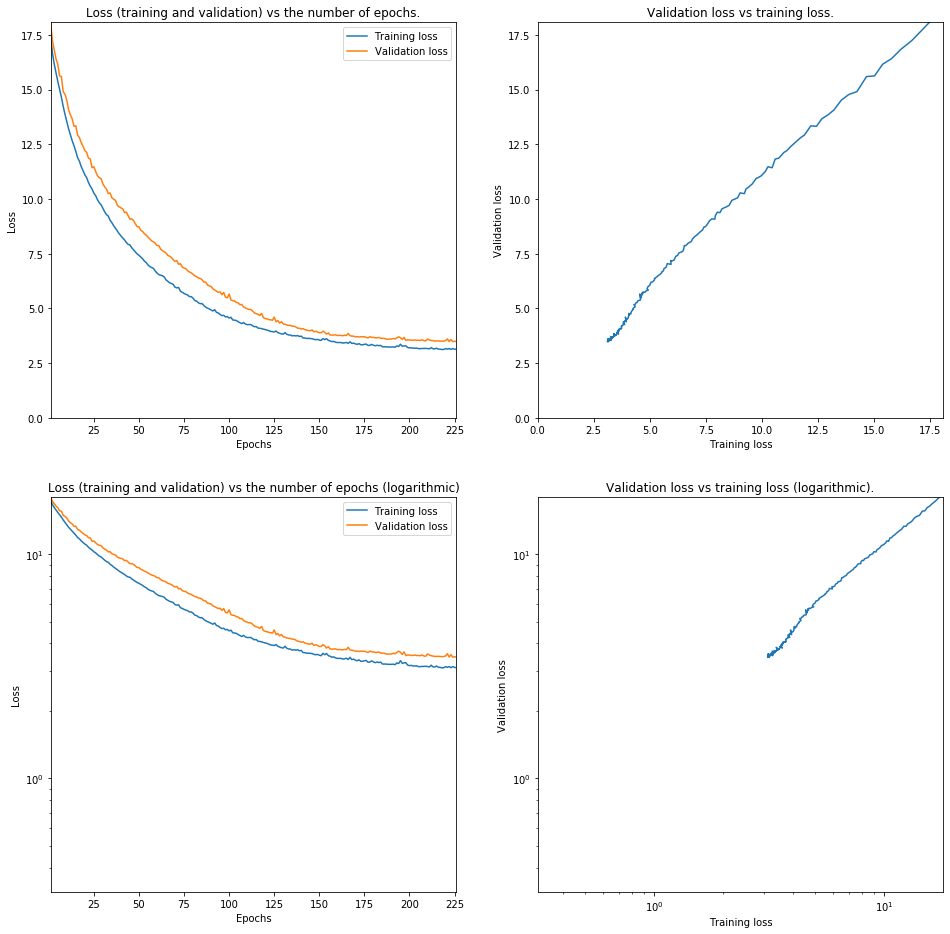

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 128)               2432      
_________________________________________________________________
dense_31 (Dense)             (None, 128)               16384     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 128       
Total params: 18,944
Trainable params: 18,944
Non-trainable params: 0
_________________________________________________________________
2.9012009196811253
Layer 0:  [array([[ 0.2761285 , -0.1359888 , -0.36996832, ..., -0.33632955,
         0.25642344,  0.3379275 ],
       [-0.34356397,  0.07292677,  0.01246221, ..., -0.29717153,
         0.10099011,  0.45809594],
       [ 0.27343076, -0.38512248,  0.40004402, ...,  0.39745283,
        -0.48845664, -0.26364088],
       ...,
       [ 0.4046788 , -0.05019353, -0.

In [151]:
fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=1000, verbose=1, callbacks=callbacksNetwork)

history = plotHistory(fitDetails)

evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

model.summary()
print(evaluation)
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

2.9012009196811253


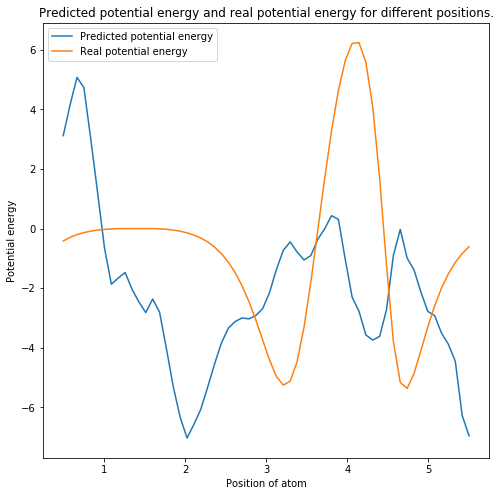

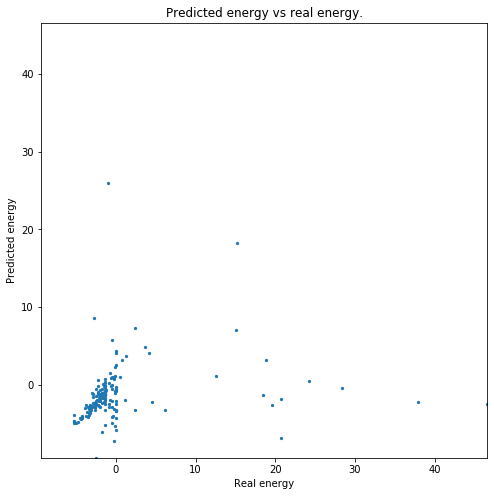

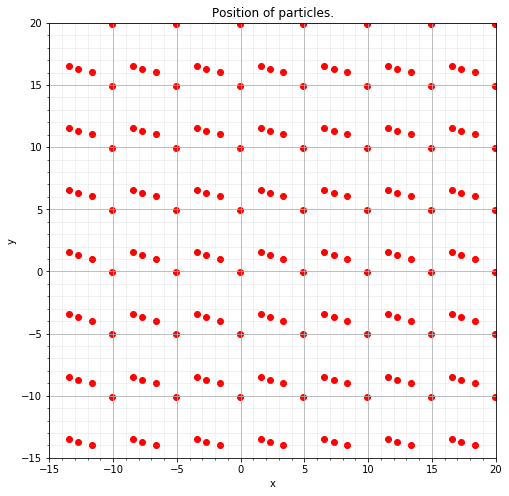

For index 754 Predicted -0.118247986 was -0.5771143634


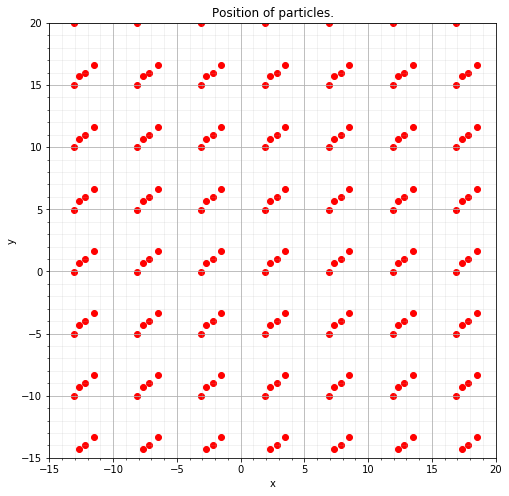

For index 35 Predicted -1.8342743 was -2.0393180157


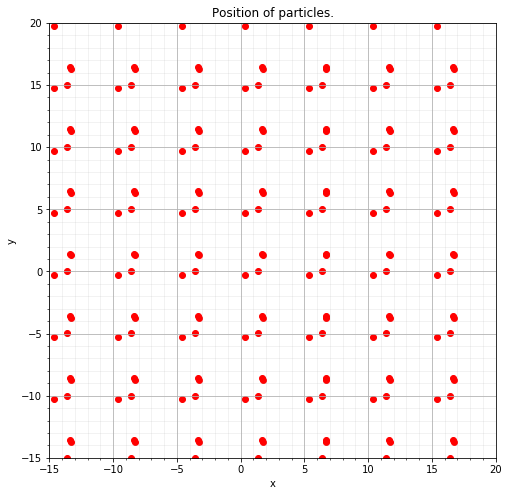

For index 354 Predicted 0.12023163 was -1.5862047633


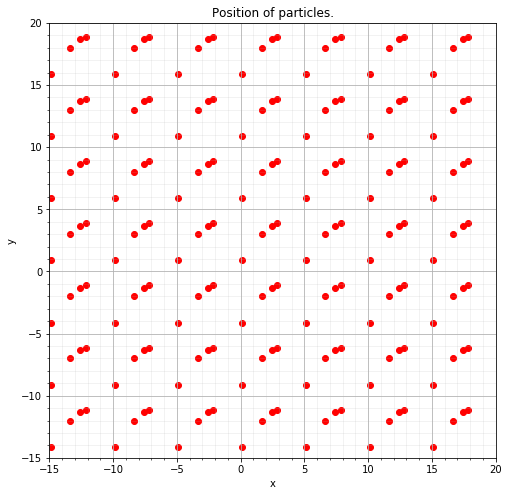

For index 788 Predicted -1.7069988 was -1.3044599910999999


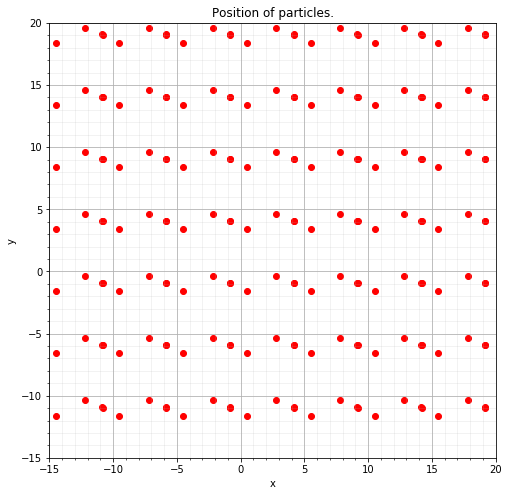

For index 278 Predicted -1.2208614 was -2.1899504979


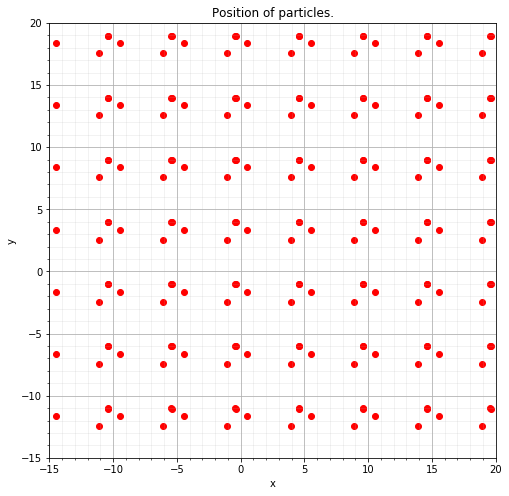

For index 142 Predicted -1.27034 was 18.4494989008


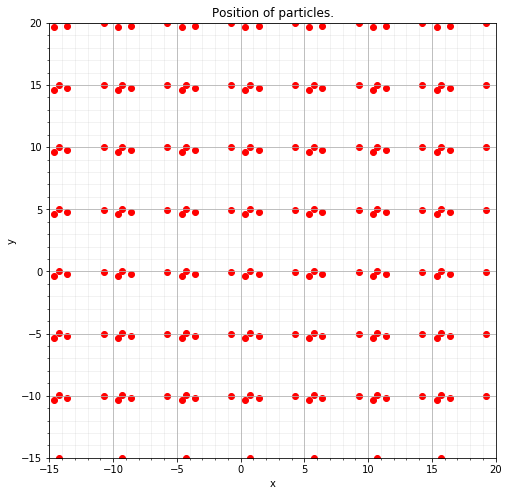

For index 548 Predicted 18.281334 was 15.2344832435


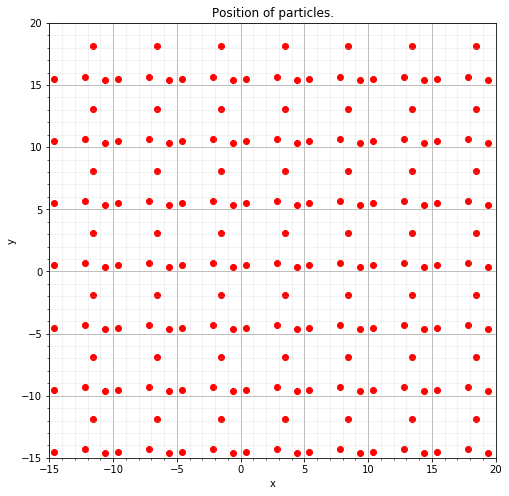

For index 517 Predicted 4.070757 was -0.018872065900000002


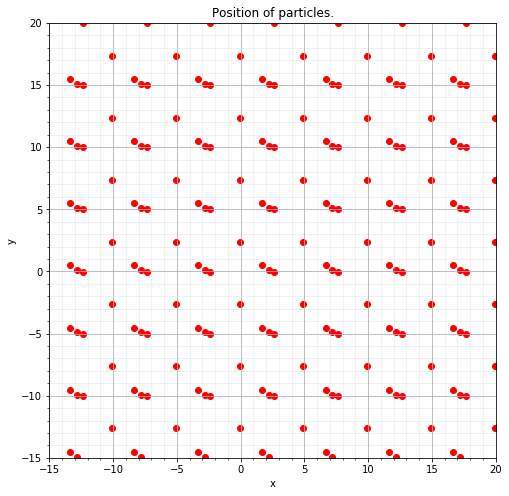

For index 583 Predicted -0.44148254 was 28.3504423379


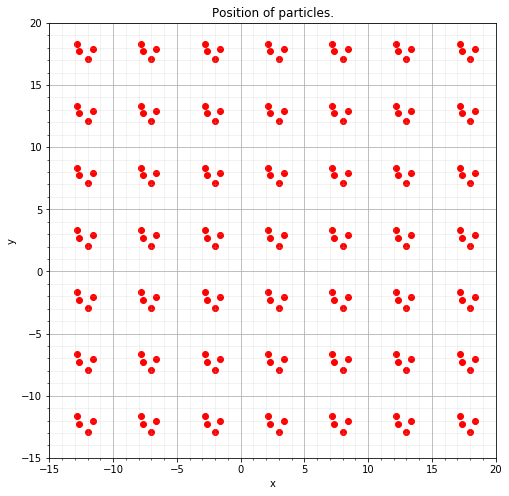

For index 336 Predicted -4.3281546 was -4.4591292936


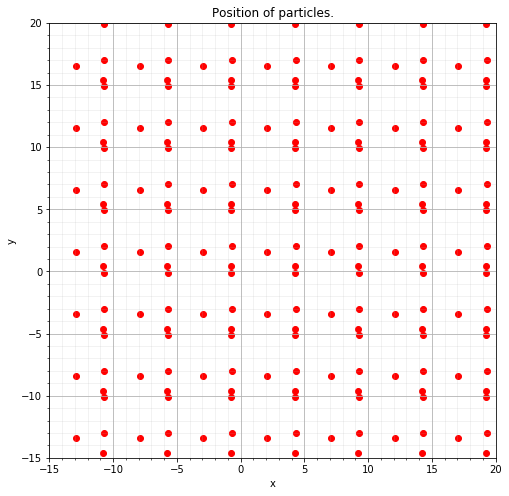

For index 657 Predicted 1.1728592 was -0.1619672391


In [152]:
print(evaluation)

y = [[],[]]
for i in range(len(x)):
    #y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[0].append(model.predict([[testData['relativeDistances'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
plt.show()

makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

# Finishing

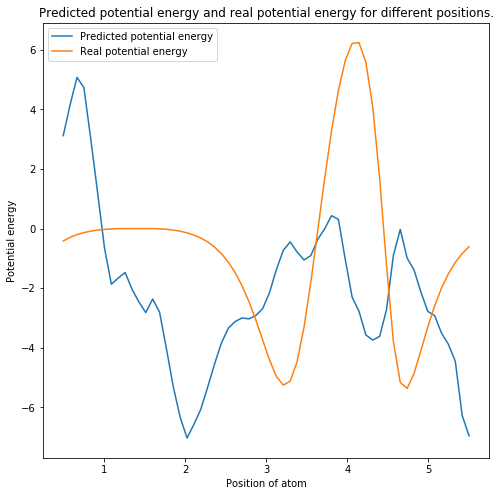

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 128)               2432      
_________________________________________________________________
dense_31 (Dense)             (None, 128)               16384     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 128       
Total params: 18,944
Trainable params: 18,944
Non-trainable params: 0
_________________________________________________________________
None
[array([[ 0.2761285 , -0.1359888 , -0.36996832, ..., -0.33632955,
         0.25642344,  0.3379275 ],
       [-0.34356397,  0.07292677,  0.01246221, ..., -0.29717153,
         0.10099011,  0.45809594],
       [ 0.27343076, -0.38512248,  0.40004402, ...,  0.39745283,
        -0.48845664, -0.26364088],
       ...,
       [ 0.4046788 , -0.05019353, -0.15886554, ..., -0.438958

In [154]:

#print(evaluation)

y = [[],[]]
for i in range(len(x)):
    #y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[0].append(model.predict([[testData['relativeDistances'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
plt.show()

"""
makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)
"""
#"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()


In [ ]:
for i in range(len(models)):
    model = models[i]['model']
    print(models[i]['name'])
    print(model.summary())
    print(models[i]['evaluation'])
    model.save(saveFolder + '/' + models[i]['name'] + str(models[i]['evaluation']) + '.h5')
    print('\n \n')

#model = models[1][0]
#model.save('model1.h5')
#model = load_model('model1.h5')

# TEMP

In [ ]:
print(np.shape(trainingInput['input']))
print(np.shape(trainingInput['target']))

In [ ]:
dataset = np.loadtxt('pima-indians-diabetes.csv', delimiter=',')
#print(dataset)
# split into input (X) and output (y) variables
X = dataset[:,0:8]
y = dataset[:,8]

print(np.shape(X))
print(np.shape(y))
print(X)
print(y)

model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X, y, epochs=150, batch_size=10)